# Explore here

In [145]:
# Your code here
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
from prophet import Prophet
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

In [85]:
df = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv')
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [86]:
df.columns

Index(['date', 'sales'], dtype='object')

In [87]:
df.shape

(366, 2)

In [88]:
df.dtypes

date      object
sales    float64
dtype: object

In [89]:
df.isna().sum()

date     0
sales    0
dtype: int64

In [90]:
df.nunique()

date     366
sales    366
dtype: int64

In [91]:
df.columns

Index(['date', 'sales'], dtype='object')

In [92]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.date

In [93]:
df.date = pd.to_datetime(df.date)
df.dtypes

date     datetime64[ns]
sales           float64
dtype: object

In [94]:
df.date.max()

Timestamp('2023-09-03 00:00:00')

In [95]:
df.date.min()

Timestamp('2022-09-03 00:00:00')

In [96]:
(df.date.max()-df.date.min()).days

365

In [97]:
df.date.nunique()

366

In [98]:
df.sales.value_counts()

sales
1000.482785    1
55.292157      1
53.803211      1
58.141693      1
64.530899      1
              ..
93.631101      1
97.788518      1
96.889768      1
94.395825      1
106.618390     1
Name: count, Length: 366, dtype: int64

In [99]:
df.date.value_counts()

date
2023-09-03    1
2022-09-03    1
2022-09-04    1
2022-09-05    1
2022-09-06    1
             ..
2022-09-20    1
2022-09-21    1
2022-09-22    1
2022-09-23    1
2022-09-24    1
Name: count, Length: 366, dtype: int64

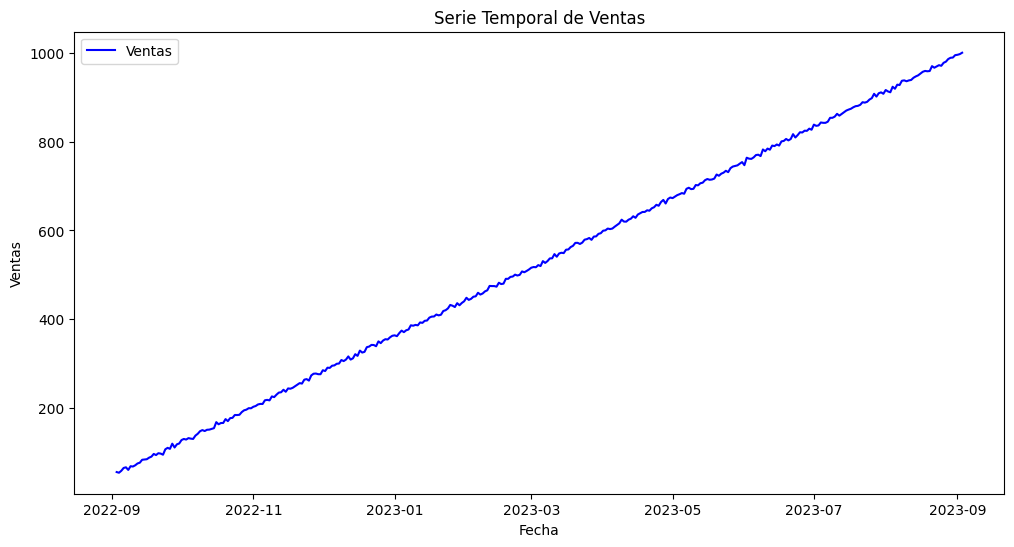

In [100]:
# Visualización de la serie temporal
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['sales'], label='Ventas', color='blue') 
plt.title('Serie Temporal de Ventas')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

In [ ]:
# Tendencia: Se aprecia una tendencia ascendente, lo que indica que el número de ventas ha aumentado a lo largo del tiempo. 

In [ ]:
# Estacionalidad: Se observa cierta estacionalidad en los datos (muy poca), con ciertos meses que consistentemente tienen más ventas que otros. Esto podría deberse a la demanda estacional

In [ ]:
# Variabilidad: Se observan ciertos puntos de variabilidad en la serie temporal, sobre todo entre los periodos de aumento y disminución en la demanda.

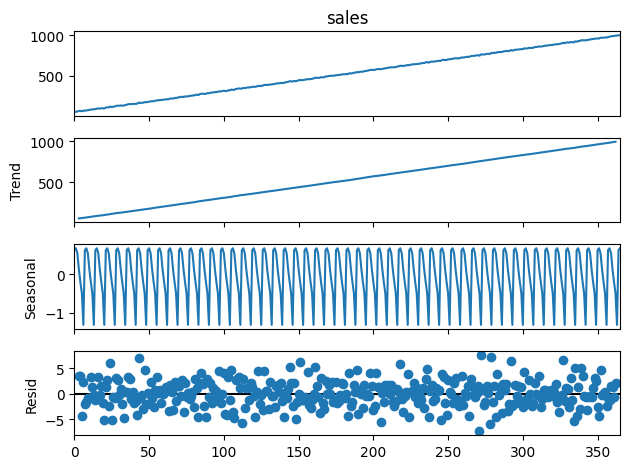

In [111]:
result = seasonal_decompose(df['sales'], model='additive', period=7)

# Graficar la descomposición
result.plot()
plt.show()

In [112]:
#Prueba de Dickey-Fuller para comprabar la media y varianza si son constates a lo largo del tiempo.

from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df['sales'])
print(f'Estadístico ADF: {adf_test[0]}')
print(f'p-valor: {adf_test[1]}')

# Interpretación del p-valor
if adf_test[1] < 0.05:
    print("La serie es estacionaria")
else:
    print("La serie no es estacionaria")

Estadístico ADF: 0.545414193706378
p-valor: 0.9861899815311064
La serie no es estacionaria


In [114]:
# Prueba de Jarque-Bera para normalidad de los residuos
jb_test = stats.jarque_bera(result.resid.dropna())
print(f'Estadístico JB: {jb_test[0]}, p-valor: {jb_test[1]}')

# Si el p-valor es mayor a 0.05, los residuos pueden ser considerados normales
if jb_test[1] > 0.05:
    print("Los residuos tienen una distribución normal (posible ruido blanco)")
else:
    print("Los residuos no siguen una distribución normal")

Estadístico JB: 0.7862256960995435, p-valor: 0.674952576206405
Los residuos tienen una distribución normal (posible ruido blanco)


In [117]:
df.dtypes

date     datetime64[ns]
sales           float64
dtype: object

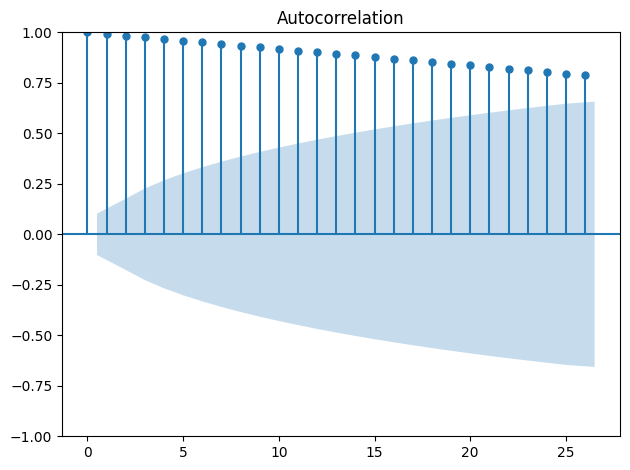

In [118]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(df['date'])

plt.tight_layout()
plt.show()


In [ ]:
# Se aprecia una alta correlación entre los puntos y sus copias retrasadas, que disminuye a lo largo del tiempo.

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  292
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -838.546
Date:                Sun, 09 Feb 2025   AIC                           1683.092
Time:                        17:02:23   BIC                           1694.112
Sample:                             0   HQIC                          1687.506
                                - 292                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.001   1863.304      0.000       0.999       1.001
ma.L1         -0.9996      0.473     -2.111      0.035      -1.928      -0.072
sigma2        18.3520      8.857      2.072      0.0

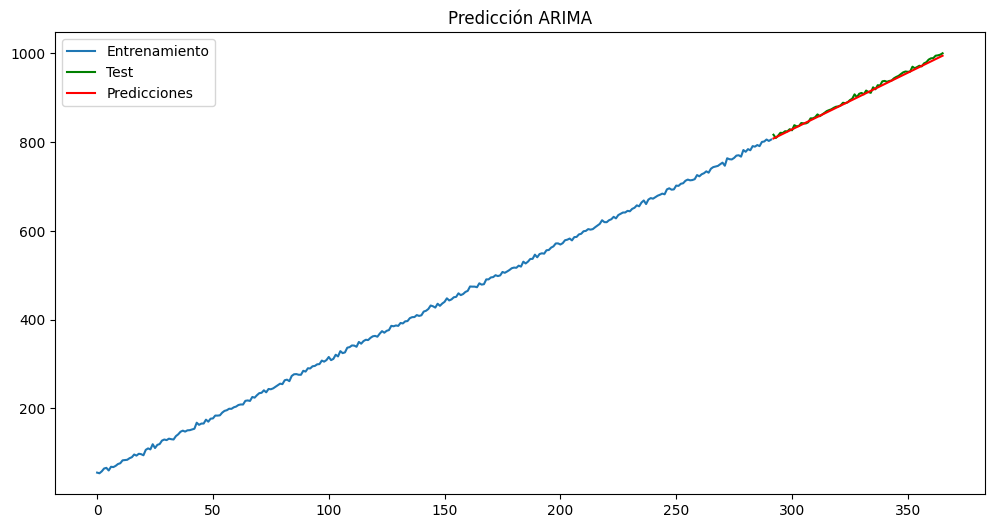

In [141]:


# Separar conjunto de entrenamiento y prueba
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Entrenamiento de modelo ARIMA
model = ARIMA(train['sales'], order=(1,1,1))  # Ajustar parámetros si es necesario
model_fit = model.fit()
print(model_fit.summary())

# Predicción y evaluación
predictions = model_fit.forecast(steps=len(test))
mae = mean_absolute_error(test['sales'], predictions)
print(f'MAE: {mae}')

plt.figure(figsize=(12,6))
plt.plot(train['sales'], label='Entrenamiento')
plt.plot(test['sales'], label='Test', color='green')
plt.plot(test.index, predictions, label='Predicciones', color='red')
plt.legend()
plt.title('Predicción ARIMA')
plt.show()